## Compressed sensing
Our aim is to study the theory behind compressed sensing and rienforce our understanding by implementing various algorithms to reconstruct a signal. 

### Theory 
In compressed sensing, our main idea is first understand in which basis is the given signal sparse and with this prioir knowledge, build a measurement matrix which will help us to undersample the signal and reconstruct it by applying appropriate algorithm to solve the reconstruction problem. Mathematically, this a problem of finding an inverse of a $n\times m$ Measurement matrix.
$$
     y  =  \Theta x 
$$
where, $\Theta$ is an $m \times n$ matrix, y is the undersampled signal which we measure and x is the sparse signal which we wish to recover. 

A natural question which arises next is, how sparse should our signal be for effective reconstruction. Before answering this question, the transformation should follow the property of isometry which is nothing but geometry of the signal should be preserved while undergoing transformation from one space to another. In practice this is not always possible. Hence  Cand`es and Tao came up with a better solution, they defined a relaxation to isometry property which is named as restricted isometry property (RIP). It is quatified as,
$$
       (1-\delta_{r})\|x\|_{2}^{2} \leqq \|\Phi\|_{2}^{2} \leqq (1 + \delta_{r})\|x\|_{2}^{2}
$$
A matrix is said to hold RIP if it follows $m>C*Slog(\frac{m}{S})$ where S is the sparsity and C is some constant for a particular instance. 

With great probabililty random measurement matrix follow RIP provided they also satisfy the above criteria. Its difficult to create the deterministic matrix for each iteration. In this work, we use partial fourier matric as our meansuremrnt matrix, but there are other kinds of measurement matrix also availabe like random Gaussian matrix. A samll note, there is an aditional condition for a good measurement matrix which is coherence between representation basis and sampling matrix to know more about this property in detail kindly refer to Introduction to compressed sensing, Emmanuel J. Candès
and Michael B. Wakin.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft,fftshift,ifft,ifftshift
import plotly.graph_objects as go
import plotly.express as xp

In this report we are going to discuss two algorithms to solve inverse problem of compressed sensing. They are Compressive Sampling Matching Pursuit (CoSAMP) and basis pursuit ($l_{1}$ norm optimization). Both methods have advantages and drawbacks which will be discussed briefly. 

Toy signal reconstruction

We will try to implement compressed sampling on a toy example which resembles natural signals.First we will implement the CoSAMP algorithm which is a greedy algorithm at its core. It;s basic idea is to assume a solution in begining and then repeatedly apply least squares to find a new estimate and update the estimate, also a halt crietria is mentioned. Here we assume the signal is s-sparse in the begining which might be drawback depending on the domain. We iterativelty try to find the best $i^{th}$ coefficient upto s coefficient in the sparse signal representation. To know more about this algorithm kindly refer to the link given in the code.

In [162]:
#https://arxiv.org/pdf/0803.2392.pdf
def cosamp(phi, u, s, epsilon=1e-10, max_iter=1000):
    """
    Return an `s`-sparse approximation of the target signal
    Input:
        - phi, sampling matrix
        - u, noisy sample vector
        - s, sparsity
    """
    a = np.zeros(phi.shape[1])
    v = u
    it = 0 # count
    halt = False
    while not halt:
        it += 1
        print("Iteration {}\r".format(it), end="")
        
        y = np.dot(np.transpose(phi), v)
        omega = np.argsort(y)[-(2*s):] # large components
        omega = np.union1d(omega, a.nonzero()[0]) 
        phiT = phi[:, omega]
        b = np.zeros(phi.shape[1])
        # Solve Least Square
        b[omega], _, _, _ = np.linalg.lstsq(phiT, u)
        
        # Get new estimate
        b[np.argsort(b)[:-s]] = 0
        a = b
        
        # Halt criterion
        v_old = v
        v = u - np.dot(phi, a)

        halt = (np.linalg.norm(v - v_old) < epsilon) or \
            np.linalg.norm(v) < epsilon or \
            it > max_iter
        
    return a

We define a signal $x$ with additive gaussian noise

In [308]:
duration = 3
sr = 4096
n = sr*duration
t = np.linspace(0,duration,n)
x = np.cos(2 * 228 * np.pi * t) + np.cos(2*850*np.pi*t + np.pi/6) + 3*np.cos(2*np.pi*1250*t) +2*np.random.rand(len(t)) 
#3.5*np.sin(2*np.pi*775*t)
#x = np.sin(2*np.pi*440*t)

Next we randomly select 128 points, which form our undersampled signal. In our example we are undersampling by 96.875% !
Reader can play around with rand_sample_no and sparsity parameter in cosamp and find that there is always a tradeoff in accuracy and speed. 

In [309]:
rand_sample_no = 128
perm = np.floor(np.random.rand(rand_sample_no) * n).astype(int)
y = x[perm]

In [310]:
from scipy.fftpack import dct,idct,fft,ifft
Psi = dct(np.identity(n))
Theta = Psi[perm,:] #create partial fourier matrix
p = cosamp(Theta,y,4) #call the cosamp alg. 4 sparse signal is assumed
xrecon = idct(p)

C:\Users\prath\AppData\Local\Temp/ipykernel_5632/1979200982.py:23: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



In [311]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=t,y=x,name='Original signal')
)
fig.add_trace(
    go.Scatter(x=t,y=xrecon.real+10,name='reconstructed signal')
)

In [249]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=t,y=dct(x),name='Original signal')
)
fig.add_trace(
    go.Scatter(x=t,y=dct(xrecon) -6000,name='reconstructed signal')
)

In [312]:
def MSE(x,xrecon):
    return np.linalg.norm(x-xrecon,2)
print(f'Mean squared error: {MSE(x,xrecon)}')

Mean squared error: 160.23117793019586


The mean squared error can be misleading in our case as we are doing a dual task of signal reconstruction and denoising. Hence a better metric would be actually listenting to the sound of the signal and judge ourselves!

In [258]:
import sounddevice as sd
import time

#duration_s = len(x)/sr
# change the first parameter to x to play original signal
sd.play(xrecon, sr)
time.sleep(duration)
sd.stop()

Convex programming

The next algorithm to solve our reconstruction problem is that of convex optimization. Lets formulate the problem formally,
$$
       Minimize \: \|x\|_{1}   \newline
       Subject\: to, \:  \|\Theta x-y\|_{2} < \delta
$$
where x is the sparse signal to be recoverd and y is the undersampled signal. 
A keen reader might argue why not we minimize $l_{0}$ quasi-norm which is simply count of number of terms in signal. The reason is that $l_{0}$ norm minimization is not a convex optimization problem and in general difficlt to solve. Hence we do a convex relaxation to $l_{1}$ norm minimization which has been proved to be effective strategy in literature. 

In [ ]:
import cvxpy as cp
x1 = cp.Variable(n)

constraints = [cp.norm(Theta@x1-y,2)<=0.0005] #contraints of our problem
obj = cp.Minimize(cp.norm(x1, 1)) # objective function 

prob = cp.Problem(obj,constraints)
prob.solve(verbose=False) # make this true to get information about how is the program trying to solve the problem
print("status: {}".format(prob.status))
print("optimal objective value: {}".format(obj.value))

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=t,y=x,name='Original signal')
)
fig.add_trace(
    go.Scatter(x=t,y=idct(x1.value),name='reconstructed signal')
)

status: optimal
optimal objective value: 5.700107390029011


You can again listen to the sound of the signal reconstructed 

In [ ]:
sd.play(idct(x1.value), sr)
time.sleep(len(x1.value)/sr)

sd.stop()

### Comparision 
We observe that although greedy algorithm was pretty fast but we need the prior information about the signal's sparsity in representation basis. There is no such requirement with convex optimization approach but the compuatation time is significantly greater. Hence, it's left to the user based on their domain knowledge which method is better. ALso in both these methods only probabilistic recovery is possible as we are choosing a partial fourier matrix as our measurement matrix. 

Reconstruct sound

Reconstructing the sound signal is difficult than simple toy problem signal. as frquency content of the signal varies with time. Hence we take a samll hamming window and reconstruct the signal at that instant and further work (not done here) will try to recombine these signals and reconstruct the original sound. 

In [305]:
from scipy.io import wavfile
sr,x = wavfile.read('example1.wav') # example music file
from scipy.signal import get_window

x = x[:,0]
print(len(x))
print(sr)
duration = len(x)/sr


win = 2048
i = 11
t_ = np.linspace(0,duration,win)

def window_sampler(x,win,i):
    
    length = len(x)
    w = get_window('hamming', win)
    temp = w*x[win*i:win*(i+1)]
    t_ = np.linspace(0,duration,len(temp))
    rand_sample_no = 1024
    perm = np.floor(np.random.rand(rand_sample_no) * len(temp)).astype(int)
    y = temp[perm]

    Psi = dct(np.identity(len(temp)))
    Theta = Psi[perm,:]
    s = cosamp(Theta,y,16)
    xrecon = idct(s)
    fig = go.Figure()
    #fig.add_trace(
       # go.Scatter(x=t_,y=temp-100,name='original signal with hanning window')
    #)
    fig.add_trace(
        go.Scatter(x=t_,y=2*xrecon-300,name='reconstructed signal')
    )
    fig.add_trace(
        go.Scatter(x=t_,y=w*x[win*i:win*(i+1)]-150,name='Hamming window product')
    )
    fig.add_trace(
        go.Scatter(x=t_,y=x[win*i:win*(i+1)],name='Original signal')
    )
    fig.show()
    return xrecon
        #todo: reconstruction
        
xrecon = window_sampler(x,win,i)



141696
44100


C:\Users\prath\AppData\Local\Temp/ipykernel_5632/1979200982.py:23: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



In [306]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=t_,y=dct(x[win*i:win*(i+1)])/500-500,name='DCT of original signal')
)
fig.add_trace(
    go.Scatter(x=t_,y=dct(xrecon)/500-600,name='DCT of reconstructed signal')
)
fig.show()

In [261]:
import sounddevice as sd
import time
sd.play(x, sr)
time.sleep(duration)
sd.stop()

A major drawback in Sound signal reconstruction with cosamp is that we don't know apriori how sparse the signal would be hence we need to guess the sparsity in order to reconstruct the signal. Hence it would not be the best approach, but reader can play around with use of convex optimization approach for this problem! 

# Event-trigerred Sampling and Machine Learning



The goal here is to learn a reconstruction algorithm for a signal which is sampled using level-trigerred sampling, with number of samples less than that required by nyquist rate.

### Generating random signals
We generate random signals for training the model, as we do not want that the model learns from the structure of signals, rather we want it to learn it from the samples taken which will be described later.

In [6]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import random

def generate_signals(
        n,
        time_length
    )-> tuple[np.array,list]:
    """
    this generates random signals with a probability of 0.5 that the ouput signal will be a single sinusoid, otherwise it will be a random signal
    (sum of sinusoids of random amplitude and frequency)
    n -> number of random signals to be generated
    time_length -> duration of the generated signals
    """
    ft = np.random.choice(800,4)
    amp = np.random.choice(6,4)
    t = np.linspace(0,time_length,100)
    def f(t,ft,amp):
        ans = 0
        random_number = np.random.randint(1, 5)
        
        if random_number <= 2:
          ans = np.sin(2*np.pi*np.random.randint(200,800)*t + random.random())
        else:
          for i in range(len(ft)):
                ans += amp[i]*np.sin(np.pi*ft[i]*t + random.random()) 
        return ans
    
    s = []
    s.append(f(t,ft,amp))
    for i in range(n-1):
        ft = np.random.choice(10,4)
        amp = np.random.choice(6,4)
        temp = f(t,ft,amp)
        s.append(temp)
    return t,s

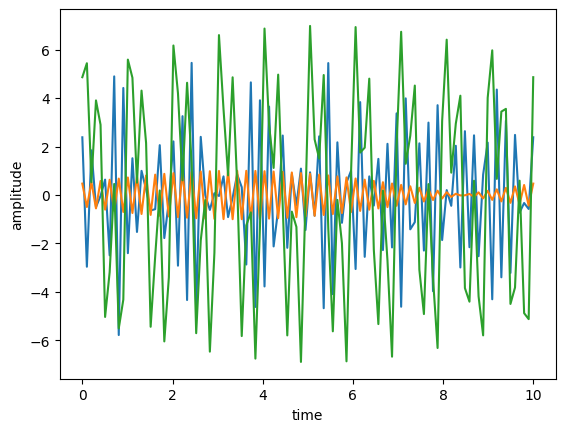

In [11]:
import matplotlib.pyplot as plt
t,s = generate_signals(3,10)
for i in range(len(s)):
  plt.plot(t,s[i],label = 'random signal' + str(i+1))
plt.xlabel('time')
plt.ylabel('amplitude')
plt.show()

### Event Trigerred Sampling
Uniform sampling has it's own drawbacks, it might not always possible to take uniform samples due to reason such as mismatched clocks and unavailability of data at equal time intervals. In event trigerred sampling samples are taken when a particular event in the signal happens, such as if the amplitude of signal crosses a certain level. This is particularly referred as level-trigerred sampling. It might be possible to reconstruct the original signal which is sampled using level-trigerred sample with samples less than that required by nyquist rate. Following is the code which returns the samples of the signals.



In [ ]:
def sampler(
        signal,
        time,
        a = 0.3,
        b = 0.6,
        c = 0.9
        ) -> list[list]:
        """
        returns the time instances at which the signal crossed the thresold values defined by the floats a,b,c. All thresold values
        should be less than 1
        the return type is a list of lists such that:-
        list[0] contains the time instances when signal crossed a
        list[1] contains the time instances when signal crossed b
        list[2] contains the time instances when signal crossed c
        list[3] contains the time instances when signal crossed -a
        list[4] contains the time instances when signal crossed -b
        list[5] contains the time instances when signal crossed -c

        """
        if( a >= b or b >=c):
            raise ValueError( 'a should be less than b and b should be less than c')
        if(a < 0 or b < 0 or c < 0):
            raise ValueError('each value should be positive')
        if(c > 1):
            raise ValueError('each of a, b, and c should be less than 1')
        
        max_amp = np.amax(signal)
        signal = signal/max_amp
        try: 
            fourier_transform = np.fft.fft(signal)
        except:
            print(signal)
        #zero out the very low values
        max_amp = np.max(abs(fourier_transform))
        try:
            for index in range(0,len(fourier_transform)):
                if(abs(fourier_transform[index])/max_amp < 1e-6): fourier_transform[index] = 0;
        except:
            print(fourier_transform)
            raise ValueError('Error while computing fourier transform')
        try:
           max_freq = np.max(np.nonzero(abs(fourier_transform))[0]) #finds the maximum freq content of signal
        except:
            print(signal)
            raise ValueError('Error while computing fourier transform')        
        
        nyquist_rate = 2*max_freq  
        num_samples = math.ceil(0.90*(time[len(time)-1] - time[0])*nyquist_rate) #number of samples that will be taken by our program

        first = []
        second = []
        third = []
        fourth = []
        fifth = []
        sixth = []
        n = len(time)
        
        count = 0 #to keep track of number of samples taken, should be less than that required by nyquist rate.
        
        if((signal[0])==a): first.append(0); count = count + 1
        if((signal[0])==b): second.appned(0); count = count + 1
        if(signal[0]==c): third.append(0); count = count + 1
        if((signal[0])==-a): fourth.append(0); count = count + 1
        if((signal[0])==-b): fifth.append(0); count = count + 1
        if(signal[0]==-c): sixth.append(0); count = count + 1

        for i in range(1,n):
            if(count >= num_samples): break;
            if(signal[i]==a): first.append(time[i]); count = count + 1;
            elif(signal[i]==b): second.appned(time[i]); count = count + 1;
            elif(signal[i]==c): third.append(time[i]); count = count + 1;
            elif(signal[i] == -a): fourth.append(time[i]); count = count + 1;
            elif(signal[i] == -b): fifth.append(time[i]); count = count + 1;
            elif(signal[i] == -c): sixth.append(time[i]); count = count + 1;
            elif(signal[i-1] < a and signal[i] > a): first.append((time[i] + time[i-1])/2); count = count + 1;
            elif(signal[i-1] > a and signal[i] < a): first.append((time[i] + time[i-1])/2); count = count + 1;
            elif(signal[i-1] < b and signal[i] > b): second.append((time[i] + time[i-1])/2); count = count + 1;
            elif(signal[i-1] > b and signal[i] < b): second.append((time[i] + time[i-1])/2); count = count + 1;
            elif(signal[i-1] < c and signal[i] > c): third.append((time[i] + time[i-1])/2); count = count + 1;
            elif(signal[i-1] > c and signal[i] < c): third.append((time[i] + time[i-1])/2); count = count + 1;
            elif(signal[i-1] < -a and signal[i] > -a): fourth.append((time[i] + time[i-1])/2); count = count + 1;
            elif(signal[i-1] > -a and signal[i] < -a): fourth.append((time[i] + time[i-1])/2); count = count + 1;
            elif(signal[i-1] < -b and signal[i] > -b): fifth.append((time[i] + time[i-1])/2); count = count + 1;
            elif(signal[i-1] > -b and signal[i] < -b): fifth.append((time[i] + time[i-1])/2); count = count + 1;
            elif(signal[i-1] < -c and signal[i] > -c): sixth.append((time[i] + time[i-1])/2); count = count + 1;
            elif(signal[i-1] > -c and signal[i] < -c): sixth.append((time[i] + time[i-1])/2); count = count + 1;
        
        mx = math.floor(num_samples/6)
        if(len(first) > mx):
            first = random.sample(first,mx)
        if(len(second) > mx):
            second = random.sample(second,mx)
        if(len(third) > mx):
            third = random.sample(third,mx)
        if(len(fourth) > mx):
            fourth = random.sample(fourth,mx)
        if(len(fifth) > mx):
            fifth = random.sample(fifth,mx)
        if(len(sixth) > mx):
            sixth = random.sample(sixth,mx)

        ret = []
        ret.append(first)
        ret.append(second)
        ret.append(third)
        ret.append(fourth)
        ret.append(fifth)
        ret.append(sixth)
        return ret

### Creating the dataset

The datset for the machine learning method was created  by generating random signals using generate signals function and then sampled at particular levels using the sampler function. Then all of the samples were padded in a single list with -1 indicating end of the current level. Also if the length of the list was less than 100 then -2 were padded in the list, to make it of size 100. Each datapoint contains 2 lists, the first lists contains the time instances at which the signal crossed the levels, the second list contains the uniformly sampled values of signal from time 0 to 10. Length of both lists is 100. Following is the code to generate the dataset


In [ ]:
def get_samples(
      n,
      time_length
    )-> list[list]:
    """
    Returns a list of list that contains the signal and time instances at which it crossed particular levels.
    n -> number of signals to be generated
    time_length -> length of signal to be generated
    output-> list of lists
    each list item of ouput contains following values 
    item[0] :-> A list of length 100 containing the time instances at which the signal crossed particular levels
    item[1] :-> The value of signals uniformly sampled at 100 instances from 0 to 10.
    """
    t,s = generate_signals(n,time_length)
    dataset = []
    for i in range(n):
      max_amp = np.max(np.abs(s[i]))
      s[i] = s[i]/(max_amp + 0.00001)
      samples = sampler(s[i],t,0.3,0.6,0.9)
      samples_flattend = []
      for list in samples:
        for val in list:
          samples_flattend.append(val)
        samples_flattend.append(-1)
      if(len(samples_flattend) < len(s[i])):
        while(len(samples_flattend) < len(s[i])): samples_flattend.append(-2)
      if(len(samples_flattend) > len(s[i])):
          while(len(samples_flattend) > len(s[i])): samples_flattend.pop()
      max_amp = np.max(np.abs(s[i]))
      data = []
      data.append(samples_flattend)
      data.append(s[i])
      dataset.append(data)  
    return dataset

### Network Architecture and Dimensionality expansion

The signal contains samples less than those required by nyquist rate, so the signal is kind of undersampled and sparse in some sense. It lacks some information. So our approach is to project it in a higher dimensional space which will add some more info to it. The model will learn what to add according to the input themselves, and then from that higher dimensional space extract out the required info and then again project it into the required dimensions. So we use a network architecture some what opposite to autoencoders that do dimension expansion first and then project it into the required dimensions. Following the model training code

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim


# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# torch.cuda.set_device(device)
# define the network class
class MyNetwork(nn.Module):
    def __init__(self):
        # call constructor from superclass
        super(MyNetwork,self).__init__()
        # define network layers
        self.fc1 = nn.Linear(100, 200)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(200, 400)
        self.dropout = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(400, 600)
        self.dropout = nn.Dropout(p=0.5)
        self.fc4 = nn.Linear(600,400)
        self.dropout = nn.Dropout(p=0.5)
        self.fc5 = nn.Linear(400,200)
        self.dropout = nn.Dropout(p=0.5)
        self.fc6 = nn.Linear(200,100)
        self.act = nn.Identity()
        
    def forward(self, x):
        # define forward pass
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.tanh(self.fc4(x))
        x = F.selu(self.fc5(x))
        x = self.act(self.fc6(x))
        return x

# instantiate the model
net = MyNetwork()
# print model architecture
print(net)
optimizer = optim.Adam(params = net.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Define the loss function


def composite_loss(y_pred,y_true):
    squared_error = (abs(torch.fft.fft(y_pred)) - abs(torch.fft.fft(y_true))) ** 2
    mse = torch.mean(squared_error)
    return mse + 75*criterion(y_pred,y_true)
# Generate some training data (100-dimensional input/output vectors)
dataset = get_samples(10000,10)
train_data = []
train_labels = []
for data in dataset:
  train_data.append(data[0])
  train_labels.append(data[1])
train_data = torch.tensor(train_data).double()
train_labels = torch.tensor(train_labels).double()
#Train the network for 10 epochs
net = net.double()
y = []
for epoch in range(20):
    running_loss = 0.0
    for i in range(train_data.size()[0]):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(train_data[i])

        # Compute the loss
        loss = composite_loss(outputs, train_labels[i])

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
    y.append(running_loss / train_data.size()[0])
    print('Epoch %d loss: %.3f' % (epoch + 1, running_loss / train_data.size()[0]))

### The Loss Function
We tried to minimize the mean square error between the fourier transforms of the the original signal and the outputted by model, added with the mean square error of the original signal and that outputted by the model in time domain. The loss function used look like following :
 $$ L = MSE(abs(FFT(y_{pred})),abs(FFT(y_{original}))) + 75(MSE(y_{pred},y_{original}))$$
here 75 is just a factor to bring the both mean square errors on the same level.

### Results
First the model was trained with random 10,000 signals on 20 epochs. The loss when plotted with number of epochs looked like following

![img](loss_final.png)

Some of the reconstructed and signals look like following

![img](output9.png)

![img](output1.png)

![img](output3.png)


Then we varied number of maximum samples allowed . A plot is shown below which show average loss taken over 80 epochs vs no. of max samples allowed as a percentage of that required by nyquist rate.

![img](nyquist.png)

Then we varied numebr of samplers. They are even because for every detector above x axis , we took a sampler below x axis. A plot of average loss over 80 epochs vs number of samples is shown.

![img](sampler.png)